In [6]:
import pymc as pm
import aesara.tensor as at
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import time

# Sec 50:  Building up to our first GP

So far in this course we've built two critical ingredients for Gaussian processes, kernel (or covariance) functions and the multivariate normal probability distribution.  In the last lesson we learned about multivariate normals.  In the lesson before that, we learned about covariance functions.  You may be able to guess what we're going to do in this lesson.  

Before we plug covariance functions into multivariate normals, we're going to throw out the wikipedia definition of a Gaussian process.

> [**A Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution**, i.e. every finite linear combination of them is normally distributed. The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space.](https://en.wikipedia.org/wiki/Gaussian_process)

By the end of the lesson, we'll build our first non-trivial Gaussian process model and apply it to realistic data.  You'll understand exactly what the first part of the definition in bold means.  By the end of the course, you'll understand the second part too -- and you'll be able to apply it in practice.  

In this lesson, we'll first take a little detour and introduce a new dataset.  It's fake data, but hopefully it appears a little realistic. Then, we'll briefly review a few concepts from regression analysis.  
- the Binomial likelihood
- link functions
- hierarchical models

These topics are covered in the advanced regression course, so if you've already seen it there this will be review.  Otherwise, we'll provide a brief description of each and give references to read further.  Then, we'll fit four models, each one increasing in complexity.  The last one will be a Gaussian process model!  Finally, we'll use our GP model to predict at new data points.  Throughout this process we'll build our intuition about why GPs work and we'll develop our technical understanding so that the definition above actually makes sense.

## The data

Say you work at a movie theater. All the movie tickets sold either come from pre-sale, or are sold right before the movie starts.  Pre-sale tickets are those sold the prior day or earily.  Depending on the particular movie and the time of day of the showing, the pre-sale to total sale fraction changes.  Our goal will be to build a model that can take in pre-sale tickets as an input, and use it to estimate the total number of tickets sold.  The model will allow us to be able to shift movie times around and still use pre-sale tickets to forecast the number of customers.  This will help guide decisions like staffing or how much popcorn to make.

Most people don't buy tickets in advance for early afternoon matinee showings.  Everyone knows that it's a pretty good bet that it won't be sold out, especially if it's a pretty normal movie and its a week or two after the initial release.  More people do this in the evening at peak times though.  Here's seven days worth of data that we've generated that describes this behavior. 

In [33]:
times = ["01:20", "02:05", "04:30", "07:00", "08:00", "08:25", "10:55"]
attendance_mu = np.asarray([11, 16, 25, 35, 42, 40, 25])
percent_presale = np.asarray([0.05, 0.06, 0.08, 0.21, 0.3, 0.26, 0.17])
n_days = 7

data = []
for i in range(n_days):
    
    attendance = np.random.poisson(lam=attendance_mu)
    presales = np.random.binomial(n=attendance, p=percent_presale)

    for j in range(len(times)):
        data.append({
            "day": i + 1,
            "time": times[j],
            "time_ix": j,
            "k_presale": presales[j],
            "n_attend": attendance[j],
        })

        
def parse_time(t):
    t = time.strptime(t, "%H:%M")
    return t.tm_hour + t.tm_min / 60
    
df = pd.DataFrame(data)
df["t"] = df["time"].apply(parse_time)
df.head()

,day,time,time_ix,k_presale,n_attend,t
0,1,01:20,0,1,16,1.333333
1,1,02:05,1,1,13,2.083333
2,1,04:30,2,0,20,4.500000
3,1,07:00,3,10,42,7.000000
4,1,08:00,4,17,49,8.000000


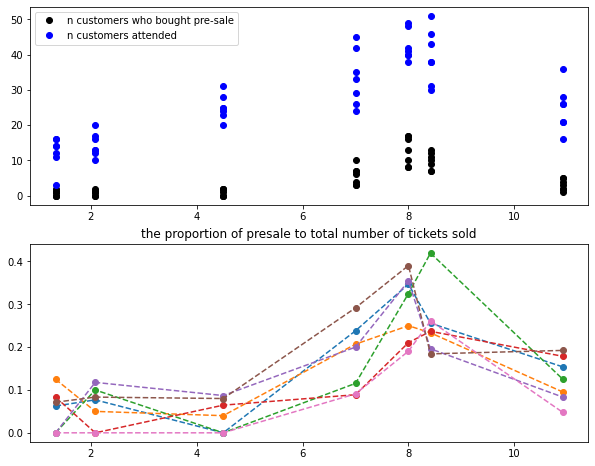

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8)); axs = axs.flatten()
axs[0].plot(df.t, df.k_presale, "ok", label="n customers who bought pre-sale")
axs[0].plot(df.t, df.n_attend, "ob", label="n customers attended")
axs[0].legend();

for _, sub in df.groupby("day"):
    axs[1].plot(sub.t, sub.k_presale / sub.n_attend, "o--")
    
axs[1].set_title("the proportion of presale to total number of tickets sold");

## Background and review

The first model will be the simplest, but we'll need to reintroduce two topics, using a Binomial distribution as the likelihood, and link functions.  

### The Binomial distribution

You may recall that a Binomial distribution describes a discrete (meaning that it's defined over integers, 1,2,3, etc.) random process that can be characterized by 3 parameters, usually denoted $n$, $k$, and $p$.  It's the distribution over the number of successes, $k$, over a series of $n$ trials.  Some examples are:
1. The number of heads, $k$, after flipping a coin $n$ times
2. The number of products that fail QC out of a total number produced that day
3. The number of times a product is returned out of the total number sold
In each of these three scenarios, there is some parameter $p$ that controls the proportion of "successes" to the total, and it's usually this parameter that we're trying to infer.  Notice that it must be a number between 0 and 1 (inclusive) because it's a proportion. 

In our movie theater example, $n$ is the total number of tickets sold, $k$ is the number of tickets sold in pre-sale ahead of time, and $p$ is the proportion of presale tickets to the total.  Try experimenting with this distribution to get a feel for how it behaves:

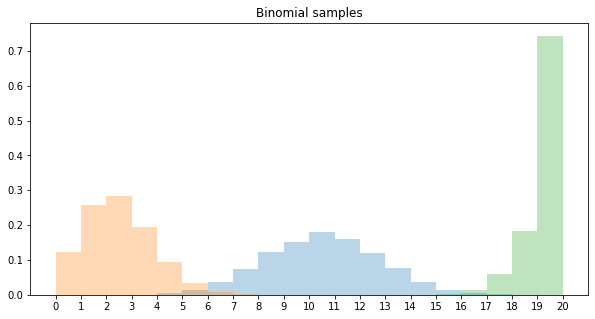

In [59]:
plt.figure(figsize=(10, 5))

s = pm.draw(pm.Binomial.dist(n=20, p=0.5), 10_000)
plt.hist(s, bins=np.arange(21), alpha=0.3, density=True);

s = pm.draw(pm.Binomial.dist(n=20, p=0.1), 10_000)
plt.hist(s, bins=np.arange(21), alpha=0.3, density=True);

s = pm.draw(pm.Binomial.dist(n=20, p=0.95), 10_000)
plt.hist(s, bins=np.arange(21), alpha=0.3, density=True);

plt.xticks(np.arange(21));
plt.title("Binomial samples");

When you use the Binomial distribution as a likelihood, you generally know $n$ and $k$ and you want to estimate $p$, or some function whose output is $p$.  That brings us to 

## Link functions

A link function is used in regression to "link" the observed data to a model we might make for it.  For Bayesian models, we'll actually only use the inverse link function (which is unfortunately a bit of a mouthful), so that's all we'll talk about here.  We use the inverse link function to transform our model into the space that's required by the likelihood function.  What does that mean?  Say we have a very simple mode for the proportion parameter $p$ of a binomial distribution, we'll call it $\mu$.  In order to guarantee that the parameter $\mu$ is between zero and one, we can apply a transformation function, such as some sort of [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) (which you may recall if you've worked with neural networks).  The most commonly used is the logistic function:

$$
p(\mu) = \frac{1}{1 + \exp(-\mu)}
$$

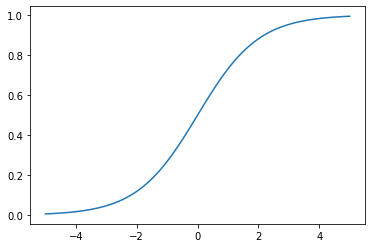

In [64]:
mu = np.linspace(-5, 5, 100)
plt.plot(x, 1.0 / (1.0 + np.exp(-mu)));

We can see that:
- when $\mu = 0$, $p(\mu) = 0.5)$
- when $\mu$ increases, $p(\mu)$ increases but eventually saturates at 1
- when $\mu$ decreases, $p(\mu)$ also decreases and eventually saturates at 0

There are many other functions that behave similarly, which have the characteristic "s" shape that starts at zero and terminates at one.  It's usually not terribly important which one you choose to use, to we'll stick to the inverse logit function, or just the "sigmoid".   

### In regression

You may be wondering why we don't just put a prior on $\mu$ that constrains it to be between 0 and 1, like a Uniform, a Beta, or a Kumaraswamy.  We could!  But, returning to our movie theater example, what if $\mu$ isn't just a parameter, but is, say, a function of time?  When it's used this way, we call it the **linear predictor**.  We can see from our data that it looks like $p$ is different for different movie times.  We hypothesized that less people buy tickets in advance for matinees.  In this case, $\mu$ is some function of time.  We shouldn't limit ourselves though.  When doing regression, we have some arbitrarily complex linear model, and we can use a sigmoid to transform it such that it can model $p$ for binomially distributed observations:

$$
\mu(\mathbf{x}) = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2 + \cdots + \beta_k * x_k
$$
The results of this linear regression aren't guaranteed to be between zero and one, so the sigmoid serves to "squash" them into probabilities.  

By the way, this isn't something that only applies to Binomial likelihoods. A Poisson distribution is parameterized by a "rate" parameter, which must be positive.  The most common inverse link function used in models with Poisson likelihoods is the exponential, because it maps all numbers, negative and positive, to only positive numbers (rates are positive!).  What about when the likelihood is normal?  There technically is an inverse link function used, but it's just the identity function.  Because it's not doing anything there's no point in mentioning it (though it's possible to use other link functions!).  

Or, as you'll see, we can use a Gaussian process for $\mu$...

## Model 1

Now that we've reviewed the Binomial distribution, likelihoods, link function and linear predictors, we're ready to make our first, most basic model.  There is no GP anywhere in sight yet!  We'll work up to it, motivating it as we go.  For the first model, we'll use just a single parameter $\mu$.  We'll use our sigmoid link function (though feel free to try experimenting with a Beta prior and no link function) to plug it into our Binomial likelihood.  We can turn all that background information into a model that takes just 3 lines of PyMC code.  The first one defines our prior on $\mu$, the second transforms it to a probability value between zero and one, and the third is the likelihood, where we pass in $n$ and the observed data, $k$.  

In [65]:
n = df["n_attend"].values
k = df["k_presale"].values

with pm.Model() as model:
   
    mu = pm.Normal("mu", mu=0.0, sigma=5.0) 
    p = pm.Deterministic("p", pm.math.sigmoid(mu))
    pm.Binomial("lik", n=n, p=p, observed=k) 
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.9006, but should be close to 0.8. Try to increase the number of tuning steps.


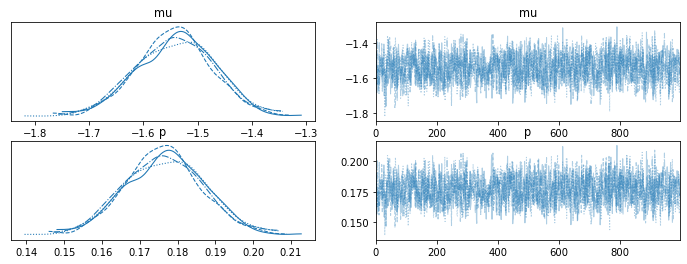

In [69]:
az.plot_trace(idata);

Next we'll plot the posterior of $p$ on top of our observed data to see if the results look reasonable.

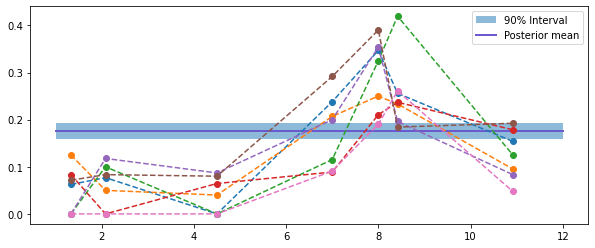

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

p = idata.posterior.p.stack(sample=["chain", "draw"]).values
lower = np.percentile(p, 5)
upper = np.percentile(p, 95)
mid = np.mean(p)

ax.fill_between([1, 12], [lower, lower], [upper, upper], alpha=0.5, label="90% Interval")
ax.plot([1, 12], [mid, mid], color="slateblue", lw=2, label="Posterior mean")

for _, sub in df.groupby("day"):
    ax.plot(sub.t, sub.k_presale / sub.n_attend, "o--")
    
ax.legend();

It's pretty clear to see that our estimate for the proportion of presale tickets is far too high, and far too confident, in the afternoons for the matinees. It's the same story for the evening shows, except it's too low.  The reason this happened is because we are using one $p$ parameter to fit the average across all of time.  Let's improve the model by using two parameters, one for the matinee period, which we'll define as before 6 o'clock, and another for the evening, which will be 6 o'clock or later.   We'll need to make an *indexing* variable that we'll call `ix` so that the correct parameter is used for the right observed data point.  

In [84]:
n = df["n_attend"].values
k = df["k_presale"].values

ix = (df["t"] >= 6).astype(int).tolist()

with pm.Model() as model:
   
    mu = pm.Normal("mu", mu=0.0, sigma=5.0, size=2)
    
    p = pm.Deterministic("p", pm.math.sigmoid(mu))
    pm.Binomial("lik", n=n, p=p[ix], observed=k) 
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


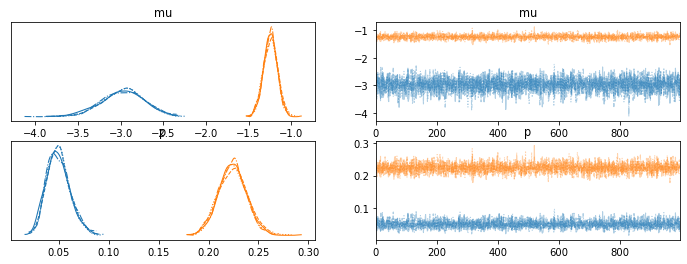

In [85]:
az.plot_trace(idata);

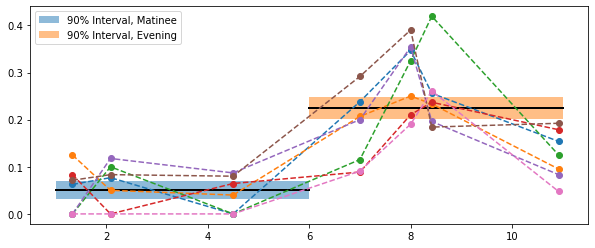

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

p = idata.posterior.p.stack(sample=["chain", "draw"]).values
lower = np.percentile(p, 5, axis=1)
upper = np.percentile(p, 95, axis=1)
mid = np.mean(p, axis=1)

ax.fill_between([1, 6], [lower[0], lower[0]], [upper[0], upper[0]], alpha=0.5, label="90% Interval, Matinee")
ax.plot([1, 6], [mid[0], mid[0]], color="k", lw=2)

ax.fill_between([6, 11], [lower[1], lower[1]], [upper[1], upper[1]], alpha=0.5, label="90% Interval, Evening")
ax.plot([6, 11], [mid[1], mid[1]], color="k", lw=2)

for _, sub in df.groupby("day"):
    ax.plot(sub.t, sub.k_presale / sub.n_attend, "o--")
    
ax.legend();

Each estimate is definitely better, and now we can make various comparisons between the matinee times and evening times using the two posteriors we have for $p$.  Even though this is better, it's still not as good as it could be.  There appears to be a smooth and gradual increase from the afternoon times to the evening times, and then another gradual decline down to the late showing.  Also, our goal isn't to estimate based on the two classifications based on afternoon and evening.  We want a model that, given a time of day and a number of presale, predicts the total number of ticket sales.  While this model can do this, it'll just predict one of these two levels depending on the input time (and the presale $k$ value).  

## Model 3

Finally, it's GP time.  Let's bring back the first part of the definition, unpack it, and see if we can build it.

> A Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution

First, 

> A Gaussian process is a stochastic process (a collection of random variables indexed by time or space)

So, a GP is a *finite* collection of random variables indexed by time or space that have a multivariate normal distribution.  So this is pretty general, it's a random vector, a list of random variables.  In our movie theater case, sure, they will be indexed by time or space.  We have seven different movie times, so we'll just use seven dimensional multivariate normal.

That was straightforward.  Let's move on to the second part of the definition.  This is where it gets a bit tricky and subtle.  



> The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space.

So, you might have paused here:

> (infinitely many) random variables

Yes, a GP lives in infinite dimensions.  But remember the first part of the definition, where it says that any **finite** collection of random variables from the GP, indexed by time or space, have a multivariate normal distribution.  What that means is, while a GP is infinite dimensions mathematically, whenever we actually work with it, it has a finite number of dimensions.

In our movie theater example, we have 7 show times:  1:20, 2:05, 4:30, 7:00, 8:00, 8:25, and 10:55. Our multivariate normal prior will have 7 dimensions, one for each show time.  But, there is an **infinite** number of times in a day!  If we canceled the 1:20 showing, what are our other options?  The movie could start at 1:20 and 34.215 seconds or any other arbitrary time. 

**So, how do we connect our 7 dimensional multivariate normal over the 7 movie times, to the infinite number of possible movie show times?**

The answer is to use our kernel *function* from the second lesson to build our 7 by 7 covariance matrix over the movie theater times.  The kernel function can take any pair of times, not just from the original seven show times.  (Note here, the terms kernel and covariance function are synonymous in the context of GPs -- this is why).  So, we can arbitrarily generate covariance matrices of any dimension.  Let's try this out and see what they look like.

First, let's start with the 7 movie theater times.  We'll plot a covariance matrix made with these side by side to one with evenly spaced times. (we are just choosing a lengthscale value of 1 for now, it doesnt matter what you choose at this point, feel free to try different values!)

In [120]:
df_one = df[df["day"] == 1]
df_one

,day,time,time_ix,k_presale,n_attend,t
0,1,01:20,0,1,16,1.333333
1,1,02:05,1,1,13,2.083333
2,1,04:30,2,0,20,4.500000
3,1,07:00,3,10,42,7.000000
4,1,08:00,4,17,49,8.000000
5,1,08:25,5,11,43,8.416667
6,1,10:55,6,4,26,10.916667


In [121]:
# first redefine core part of the kernel (or covariance) function
def exp_quad(x, x_prime, lengthscale):
    return np.exp( -0.5 * np.square(x - x_prime) / lengthscale**2)

# Then define the kernel function
def kernel_function(t, t_prime, lengthscale):
    n_t = len(np.unique(t))
    n_t_prime = len(np.unique(t_prime))
    
    K = np.zeros((n_t, n_t_prime))
    for i, t_i in enumerate(t):
        for j, t_j_prime in enumerate(t_prime):
            K[i, j] = exp_quad(t_i, t_j_prime, lengthscale)
            
    return K

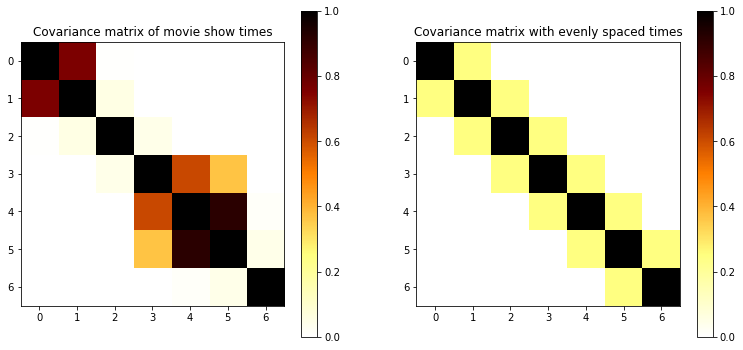

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))

t_showtimes = df_one["t"].values
K1 = kernel_function(t_showtimes, t_showtimes, lengthscale=1.0)
m = axs[0].imshow(K1, cmap="afmhot_r"); plt.colorbar(m, ax=axs[0]);
axs[0].set_title("Covariance matrix of movie show times")

t = np.linspace(1, 11, 7)
K2 = kernel_function(t, t, lengthscale=1.0)
m = axs[1].imshow(K2, cmap="afmhot_r"); plt.colorbar(m, ax=axs[1]);
axs[1].set_title("Covariance matrix with evenly spaced times");

And here is a display of the two sets of time points below.  The reason the covariance values in the matrix on the left aren't "even", like on the right side, is because the showtimes aren't evenly spaced.  The "distance", as measured by minutes, isn't the same.  On the right side, the difference between subsequent times are the same.

In [126]:
pd.DataFrame({
    "t_showtime": t_showtimes,
    "t": t,
})

,t_showtime,t
0,1.333333,1.000000
1,2.083333,2.666667
2,4.500000,4.333333
3,7.000000,6.000000
4,8.000000,7.666667
5,8.416667,9.333333
6,10.916667,11.000000


As we make the next series of plots, the question is, **are we looking at different views of the same thing?**  Let's plot the covariance function again, but using increasing time granularity, until it's not pixely any more.  Remember from the previous lesson, if a multivariate normal is 7 dimensional, the covariance matrix will be 7 by 7.  If the multivariate is 100 dimensional, the covariance matrix will be 100 by 100, etc.

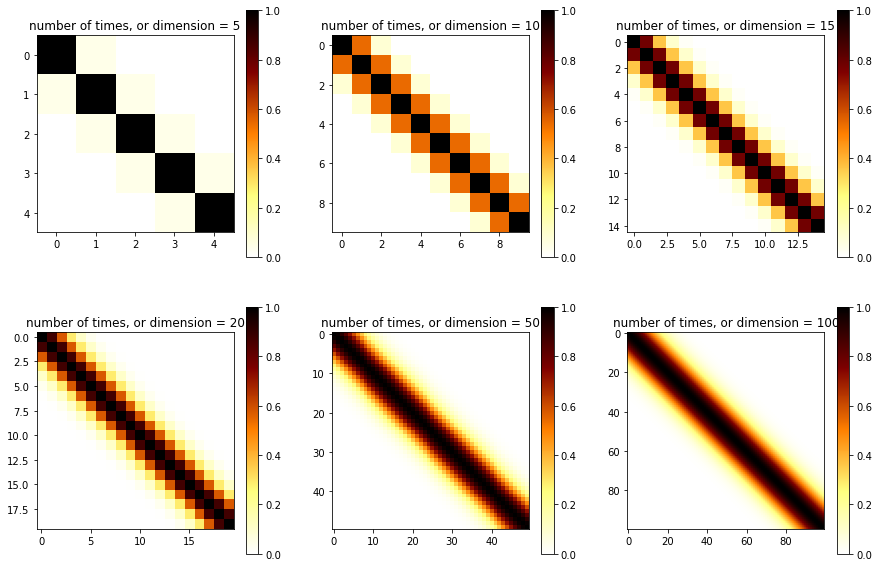

In [131]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

sizes = [5, 10, 15, 20, 50, 100]

for i, n in enumerate(sizes):
    
    t = np.linspace(1, 11, n)
    
    K = kernel_function(t, t, lengthscale=1.0)
    m = axs[i].imshow(K, cmap="afmhot_r"); plt.colorbar(m, ax=axs[i]);
    axs[i].set_title("number of times, or dimension = %s" % n)

So, as we increase the number of different time points **we're still looking at the same thing** just in higher resolution!  What we're looking at, specifically, is the covariance matrix of the GP.  

Next, let's make the same plot, but where we instead show 3 samples from the GP prior.  These will be three samples drawn from a n dimensional multivariate normal, where we increase n from 5 to 100 like we did above.

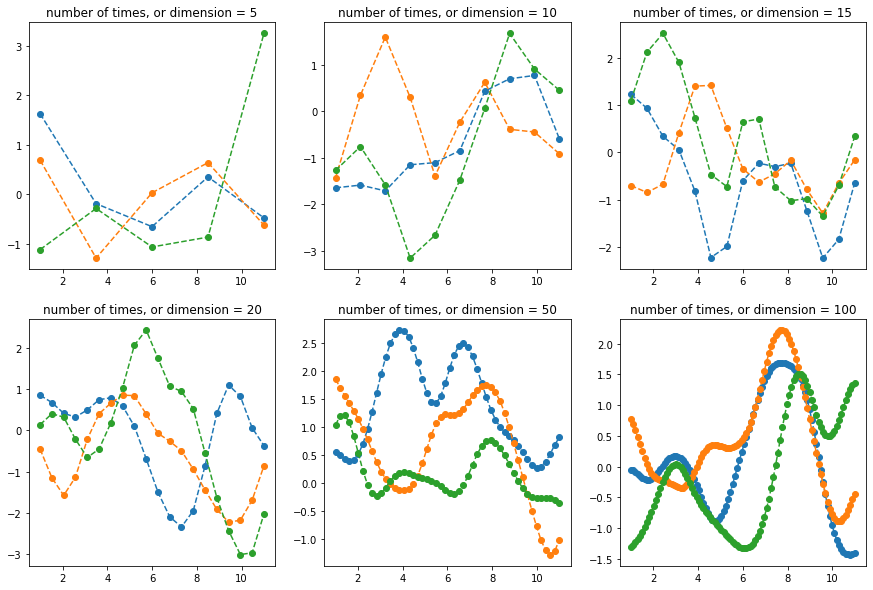

In [138]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

sizes = [5, 10, 15, 20, 50, 100]

for i, n in enumerate(sizes):
    
    t = np.linspace(1, 11, n)
    K = kernel_function(t, t, lengthscale=1.0)
    
    s = pm.draw(pm.MvNormal.dist(mu=np.zeros(len(t)), cov=K), 3)
    axs[i].plot(t, s.T, "o--")
    
    axs[i].set_title("number of times, or dimension = %s" % n)

All of these samples from the **GP prior distribution** have this same characteristic smoothness, and the same rate at which they they change over time (controlled by the lengthscale).  **This is what defines a GP**.  

This thing is doing this wiggelyness in infinite dimensions where it has perfect resolution, but we are only going to ever work with finite, lower resolution versions of it.  And that's fine!  We're doing our work on a computer, with finite data sets.  Computers can't represent infinite dimensional things, and the datasets you'll be fitting won't have an infinite number of rows, so everything works out fine. 

There is one place where it's very easy to represent infinite dimensions, and that's mathematically.  Below is how you write a GP down in math.  This particular GP's name is $f$, and it's defined over $x$:
$$
f(x) \sim \mathcal{GP}\left(0, k(x, x')\right) \,.
$$
You can tell it's infinite dimensional because $x$ can have an infinite number of values.  The function $f(x)$ is free to go anywhere, and returns a value for any $x$.  But, if we have a set of specific values, say $\mathbf{x} = [1, 2, 3]$.  Now, we plug this into the covariance *function* $k$, and get a 3 by 3 covariance matrix that was evaluated with $\mathbf{x} = x$ and $\mathbf{x'} = x$, which we'll label $\mathbf{K}_{xx}$, we'll get a three dimensional $\mathbf{f}_x$, whose distribution is a multivariate normal:
$$
\mathbf{f}_x \sim \mathcal{N}\left(0, \mathbf{K}_{xx} \right) \,.
$$

So that's it, that's a GP prior.  Oh right, we were working on a model?

## Model 3, with a GP this time

Ok, now let's make a GP model for $p$, the percentage of total ticket sales that are presales.  Except now, we'll explicitly model $p$ as a function of time $t$, so $p(t)$, using a Gaussian process.  Mathematically, it's

$$
\begin{align}
f(t) &\sim \mathcal{GP}\left(0, k(t, t')\right) \\
p(t) &= \frac{1}{1 + \exp(f(t))} \\
\end{align}
$$

where you'll recognize the bottom function as the sigmoid we introduced early.  It transforms the GP $f(t)$ to something that is bounded between zero and one (GPs are multivariate normals, so they can always range from $-\infty$ to $+\infty$).  

Next, we'll write the code in PyMC.  Later, we'll use the PyMC GP submodule to make things easier, but for now in this lesson, we'll write the whole GP out from scratch, without using GP specific code.  The purpose is to make it clear that the model we are making follows the definition of a Gaussian process, so it's clear what we're doing.  We will rewrite it in the end though, just for the sake of comparison.  The model is as follows below.  Most of this should be familiar from models 1 and 2, everything except the new GP.

In [143]:
from aesara.tensor.slinalg import cholesky

n = df["n_attend"].values
k = df["k_presale"].values

n_t = df["time"].nunique()

with pm.Model() as model:
    
    # Define the covariance function, `cov`.  We'll look more at these priors later
    eta = pm.HalfNormal("eta", sigma=1.0)
    ell = pm.InverseGamma("ell", mu=4, sigma=2)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    X = df_one["t"].values[:, None]
    K = cov(X, X)
    
    # Always use the non-centered parameterization for the multivariate normal.  
    # The thre lines following "f = pm.MvNormal.." are mathematically equivalent 
    # to the following commented out line, but are much more numerically stable
    # and easier to sample from.
    #f = pm.MvNormal("f", mu=np.zeros(n_t), cov=K)
    K = pm.gp.util.stabilize(K)
    L = cholesky(K)
    v = pm.Normal("v", mu=0.0, sigma=1.0, size=n_t)
    f = pm.Deterministic("f", L @ v)
   
    # Squash the GP into the sigmoid function
    p = pm.Deterministic("p", pm.math.sigmoid(f))
    
    # Index it into the likelihood
    t_ix = df["time_ix"].tolist()
    pm.Binomial("lik", n=n, p=p[t_ix], observed=k) 
    
    idata = pm.sample(target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, ell, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 241 seconds.


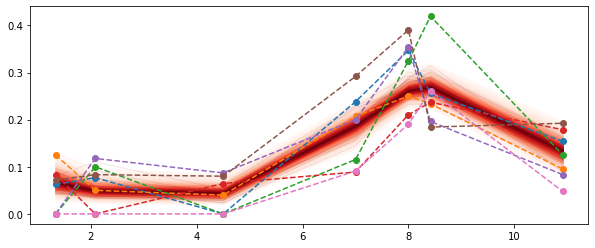

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

p = idata.posterior.p.stack(sample=["chain", "draw"]).values
pm.gp.util.plot_gp_dist(ax, p.T, X.flatten());

for _, sub in df.groupby("day"):
    ax.plot(sub.t, sub.k_presale / sub.n_attend, "o--")

Now this is much more like it.  But even though we used a function that makes nice smooth looking plots, if you look closely there are the same 7 locations that were fit, and the plot points are connected by straight lines.

We are almost, almost done.  There's one last issue here then.  How do we predict to new points?  So, there is a way around this, and it's very important, but we'll cover it in a later lesson (we need to use the conditional distribution of the GP).   

In order to predict on new points that weren't part of the training set using a GP, we just fit our GP at a higher resolution.  Fitting at the exact resolution of the data is the bare minimum we need to train our model.  By increasing the resolution, we are uncovering more of the infinite dimensional GP that we can use for what we need.  Picture an archeologist digging up and dusting off more and more of a buried dinosaur fossil.  Just because you havent uncovered all of it, doesn't mean the whole dinosaur isn't there. But you first focus on the parts you're most interested in. 

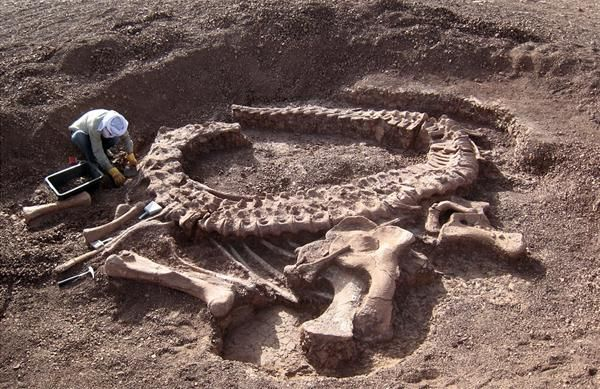

The higher resolution points to time points that weren't in the training data.  This is just another way of saying that these are the points where we are making predictions.  You still need to have the original training data in there though, or else you wouldn't be able to fit the data.  Here's this new model, with the extended, higher resolution GP.

In [ ]:
from aesara.tensor.slinalg import cholesky

n = df["n_attend"].values
k = df["k_presale"].values

with pm.Model() as model:
    
    # Define the covariance function, `cov`.  We'll look more at these priors later
    eta = pm.HalfNormal("eta", sigma=1.0)
    ell = pm.InverseGamma("ell", mu=4, sigma=2)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    t_train = df_one["t"].values[:, None]
    t_additional = np.linspace(0, 14, 50)[:, None]
    X = np.vstack((t_train, t_additional))
    
    K = cov(X, X)
    
    K = pm.gp.util.stabilize(K)
    L = cholesky(K)
    v = pm.Normal("v", mu=0.0, sigma=1.0, size=X.shape[0]) 
    c = pm.Normal("c", mu=0.0, sigma=2.0) # additive mean level
    f = pm.Deterministic("f", c + L @ v)
   
    # Squash the GP into the sigmoid function
    p = pm.Deterministic("p", pm.math.sigmoid(f))
    
    # Index it into the likelihood
    t_ix = df["time_ix"].tolist()
    pm.Binomial("lik", n=n, p=p[:n_t][t_ix], observed=k) 
    
    idata = pm.sample(target_accept=0.85)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, ell, v, c]
INFO:pymc:NUTS: [eta, ell, v, c]


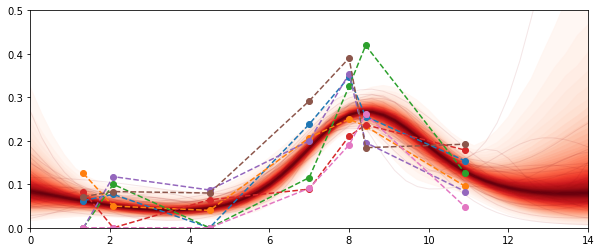

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

p = idata.posterior.p.stack(sample=["chain", "draw"]).values
pm.gp.util.plot_gp_dist(ax, p[7:, :].T, X[7:, :].flatten());

for _, sub in df.groupby("day"):
    ax.plot(sub.t, sub.k_presale / sub.n_attend, "o--")
    
ax.set_ylim([0.0, 0.5]);
ax.set_xlim([0.0, 14.0]);

# Sec 50: So can we use multivariate normals as priors?

Yes!  We certainly can.  But why?  There's no reason priors have to be univariate, or over one scalar parameter at a time.  As you know, a prior that's one dimensional describes what we think about the range of values some unknown parameter might take, and how likely different numbers are in that range.  A multidimensional, or *multivariate*, prior does that as well for multiple variables, **and** it tells the model that these parameters are related somehow.  This may seem like a small detail, but you'll see how important it is to modeling.  It's the reason GPs work so well.



## The data

We have some data on Restaurant customers provided by Ravin (Ravin want to describe this more?).  Below we plot two views of the data, the number of customers per hour and the number of customers per day.  There are 14 days, and 12 hours per day. 

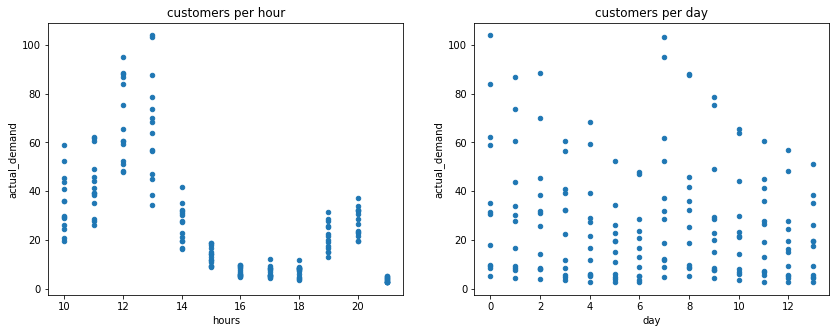

In [284]:
hours = np.asarray([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
mean_demand = np.asarray([50, 60, 100, 90, 40, 20, 10, 10, 10, 30, 40, 5])
daily_trend_factor = np.asarray([1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.5, ])

df = pd.DataFrame({"hours":hours, "mean_demand":mean_demand})
df.index.name = "hour_index"
df.reset_index(inplace=True)

# Repeat for 14 days
days_observed = 14
df_all_days = []
for i in range(days_observed):
    df_day = df.copy()
    df_day["mean_demand"] = df_day["mean_demand"] * daily_trend_factor[i]
    df_day["day"] = i
    df_all_days.append(df_day)
df_all_days = pd.concat(df_all_days)    

# Add proportional random noise
scaling = 9
var = stats.norm(0, df_all_days["mean_demand"]/scaling).rvs()
var[:10]

df_all_days["actual_demand"] = df_all_days["mean_demand"] + var


fig, axs = plt.subplots(1, 2, figsize=(14,5))
df_all_days.plot(kind="scatter", x="hours", y="actual_demand", ax=axs[0])
df_all_days.plot(kind="scatter", x="day", y="actual_demand", ax=axs[1])
axs[0].set_title("customers per hour")
axs[1].set_title("customers per day");

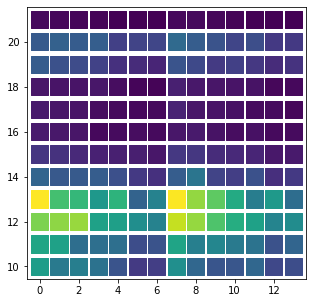

In [285]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.scatter(df_all_days.day, df_all_days.hours, c=df_all_days.actual_demand, s=300, marker="s");


Our goal is first to estimate the number of customers that come into the restaurant per hour.  Since you can see how the data is generated, there are a few observations we can make that we'll want to eventually be able to represent in our model (though keep in mind, we're working up to it slowly).  

1. Hourly changes: From 10am to 1pm the number of customers increaases, then it drops, bottoms out, and there's a bit of a dinner crowd.  Clearly this is a lunch place.  We'll want to be able to represent this pattern in our model.

2. Daily changes: Over 14 days, so two weeks, there is a peak at Monday which gradually decreases to a minimum on the weekend.  Then its back the next Monday. 

3. If we plot these as a heatmap, we can see both trends at the same time.

Before we start the process of working up to the GP, we need to choose the appropriate likelihood. We have to do this for any model we might make, whether there is a GP involved or not.  In this case a Poisson distribution makes sense because it's useful for describing counts and rates.  

### Aside: A little terminology, link functions and the linear predictor

This might be review, but if not, we'll quickly introduce two bits of terminology here that will make the rest of the lesson much easier to understand.  Thse two things aren't related to GPs, but we'll need to talk about them all the time becayse they are fundamental when building regression models.  The first is the **linear predictor**.  You've probably seen a linear model written as
$$
\mu = \beta_0 + x_1 \beta_1 + x_2 \beta_2
$$
or equivalently in matrix notation
$$
\mu = \mathbf{X}\boldsymbol\beta
$$
where $x$ is your input data and the $\beta$s are unknown parameters.  The sum (often denoted $\mu$ or $\eta$) is called the linear predictor, because it's the linear part of the model that predicts.  Linear means we're adding x times $\beta$ terms.  

If your likelihood is Gaussian, or even Student-T, you set the mean parameter of your likelihood to the linear predictor.  However, if your likelihood is something else, like Binomial or Poisson, there are more restrictions.  The rate parameter of a Poisson distribution must be positive, negative values don't work because negative rate parameters don't make sense.  If you try to run it PyMC, you'll see this error `ValueError: lam < 0 or lam is NaN`.  Therefore, we need a way to make sure these values can't happen.

To make sure the rate parameter (or more specifically, the linear predictor for rate) for a Poisson distribution always stays positive, we can exponentiate it.  The inverse of the **link function** is a function you use to transform the linear predictor to have the correct range of values.  There are often multiple options, but the most commonly used link function for the Poisson likelihood is the *log link* (the inverse link function is the exponential).  Another choice that's less popular is the square root link (exercise: switch the log link below with the square root link and see if it performs well). 

## Sec 51: First model

We'll start very simple, and just choose a single rate parameter which will represent the number of customers per hour, for all hours.  our linear predictor is just a single unknown parameter, $\mu$.  To illustrate the point, we'll also take just the first day of the data set for now.  We'll add things back in later, but doing this will really help illustrate the power of GPs.

The model is below.  It's just 4 lines of code, but make sure you understand what each line is doing.  We need to clear our headspace to make room for GPs, so it's important to have a precise understanding of what's happening around them in the model (as you'll see, we have to do this since it doesn't actually make sense to *just* have a GP only model.  There are other things happening like the likelihood and the link function and it's important to keep them identified).  

Inside the `with` block, we have 4 lines of code.  The first line defines `mu`, our prior on the log of the rate.   The second is the inverse of the link function.  We need to exponentiate `mu` using the inverse link function to guarantee that it takes only positive values.

In [299]:
df_first_day = df_all_days[df_all_days["day"].isin([0, 1])]

def inv_link(x):
    return pm.math.exp(x)

with pm.Model() as model:
    # the linear predictor
    mu = pm.Normal("mu", mu=0.0, sigma=5.0)
    
    # the rate is the transformed link function
    rate = inv_link(mu)
    
    pm.Poisson("demand", mu=rate, observed=df_first_day["actual_demand"].values)
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


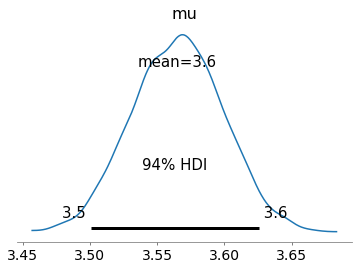

In [300]:
az.plot_posterior(idata, var_names="mu");

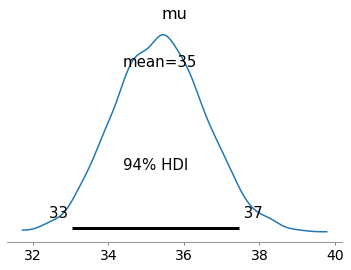

In [301]:
az.plot_posterior(idata, var_names="mu", transform=np.exp);

First, note that we can use the inverse link function to transform the linear prediction to a meaningful value.  It's $\exp(\mu)$ that's the rate, not $\mu$ itself.  `Arviz` has the built-in argument `transform` just for this purpose.

From this result we can learn that we can be fairly certain that the mean over the 12 points of data we have
is somewhere between 36 and 43.  Clearly though this isn't going to be a great model, there's more happening in the data that we need to account for.

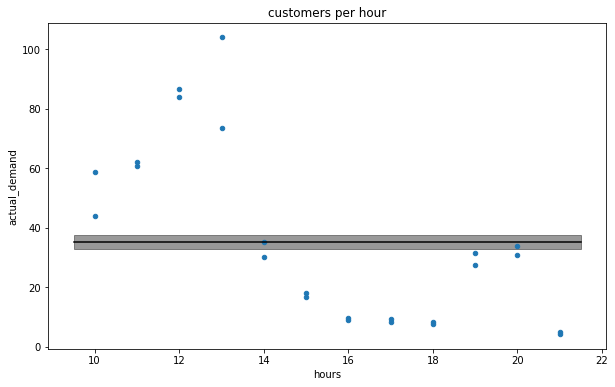

In [302]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
df_first_day.plot(kind="scatter", x="hours", y="actual_demand", ax=ax)
ax.set_title("customers per hour")
mu = idata.posterior.mu.stack(sample=["chain", "draw"]).values

s = np.exp(mu)
lower, upper = az.hdi(s)
mid = [np.median(s)]*2

lb, ub = [lower]*2, [upper]*2
x = [10 - 0.5, 21 + 0.5]
    
ax.plot(x, mid, color="k")
ax.fill_between(x, lb, ub, color="k", alpha=0.4, zorder=-99);

## Second model

Now, let's generalize a bit and use different factors for each hour.  Now instead of one parameter there will be 12.  There are actually a lot of different ways to code it up.  We'll do it the straightforward way, and just have one parameter per hour.  This way is simplest in this scenario and we can use it because we only have one factor, just the hour.  Since this course isn't about regression, we wont dig into this more.  To code it up we just extend `mu` out to a vector that has one element per each hour.   

In [303]:
hour_index = df_first_day["hour_index"].values

coords = {
    "hour": np.sort(df_all_days.hours.unique()).tolist() 
}
with pm.Model(coords=coords) as model:
    # the linear predictor
    mu = pm.Normal("mu", mu=0.0, sigma=20.0, dims="hour")
    
    # the rate is the transformed link function, index each our correctly so it matches the data
    rate = inv_link(mu)[hour_index]
    
    # the likelihood
    pm.Poisson("demand", mu=rate, observed=df_first_day["actual_demand"].values)
   
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [304]:
print("Number of divergences:", int(idata.sample_stats.diverging.sum()))

Number of divergences: 0


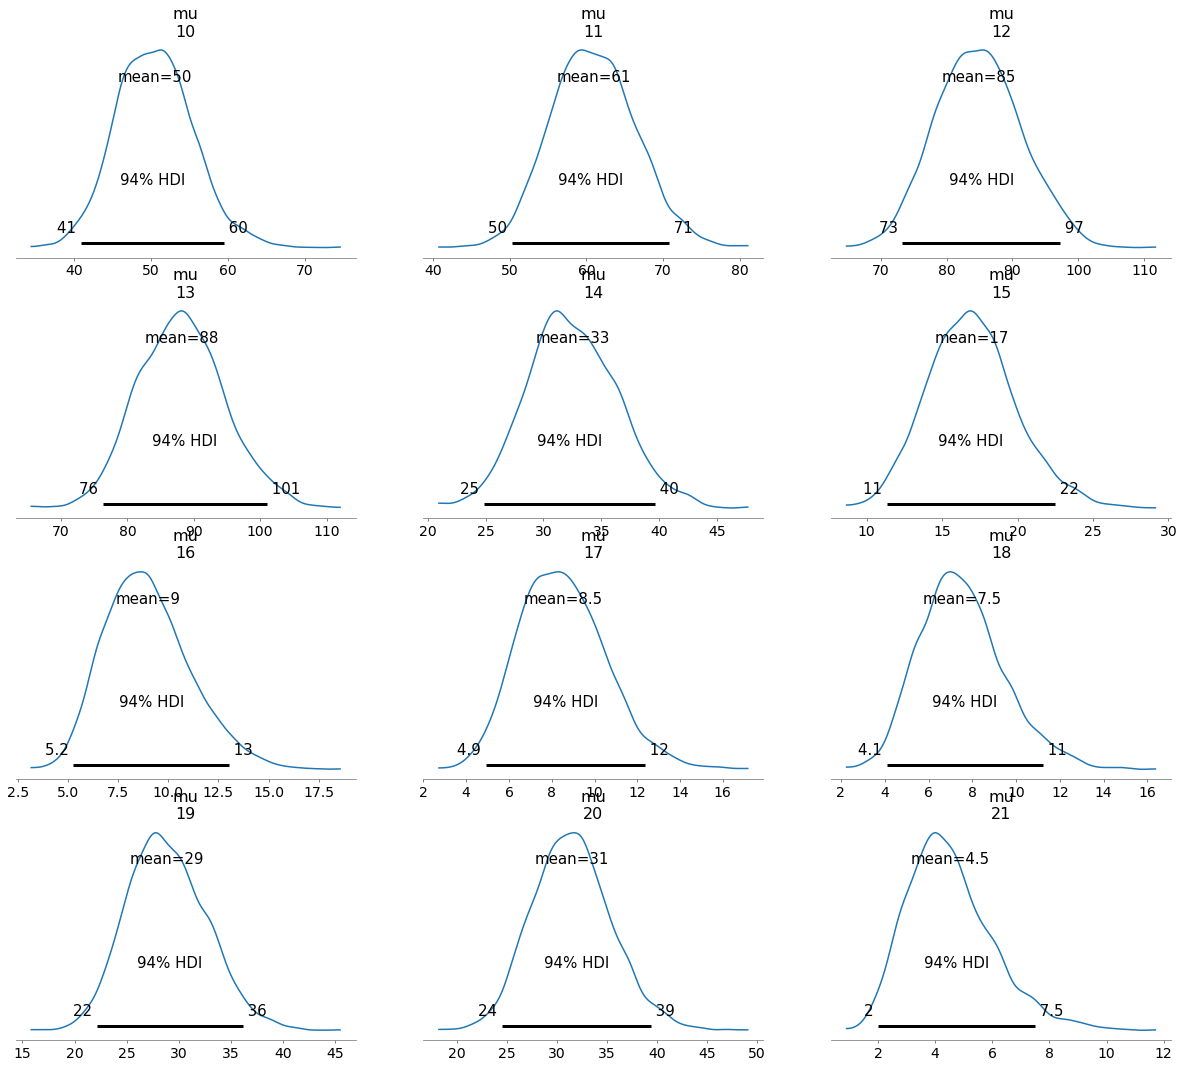

In [305]:
az.plot_posterior(idata, var_names="mu", transform=np.exp);

Now let's look at our posteriors on the same scale as our data

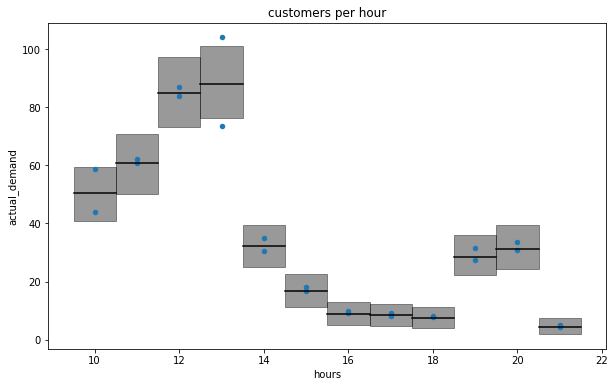

In [306]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
df_first_day.plot(kind="scatter", x="hours", y="actual_demand", ax=ax)
ax.set_title("customers per hour")
mu = idata.posterior.mu.stack(sample=["chain", "draw"])

hours = model.coords["hour"]
for i, hour in enumerate(hours):
    
    s = np.exp(mu.sel(hour=hour))
    lower, upper = az.hdi(s.values)
    
    mid = [np.median(s)]*2
    lb, ub = [lower]*2, [upper]*2
    x = [hour - 0.5, hour + 0.5]
    
    ax.plot(x, mid, color="k")
    ax.fill_between(x, lb, ub, color="k", alpha=0.4, zorder=-99)

This is interesting, but we only have one (!) observed data point per hour, and the posterior intervals are very wide.  The reason for this is because the likelihood is a Poisson distribution.  The mean and variance for a Poisson are equal to each other.  This is why the posterior width increases when the `actual_demand` increases.

We already reviewed some topics from regression.  Link functions and likelihoods.  Now let's remember hierarchical models.  The model we just made is equivalent to making 12 separate models and fitting them, one for each data point.  It sounds strange, but you're welcome to try it for yourself.  This is called the "no-pooling" model.  Information about different hours is **not** pooled together.  The first model we made was the "complete-pooling" model.  Information about different hours was put together and represented by one single parameter.  Hierarchical models lie in between.  They implement "partial-pooling", where the amount of information shared between parameters depends on their variances.  Since hierarchical models are a topic unto themselves, we won't describe the further here.  See BLANK for more information.

In [307]:
hour_index = df_first_day["hour_index"].values

coords = {
    "hour": np.sort(df_all_days.hours.unique()).tolist() 
}
with pm.Model(coords=coords) as model:
    # the linear predictor
    mu_overall = pm.Normal("mu_overall", mu=0.0, sigma=20.0)
    sigma_hour = pm.HalfNormal("sigma_hour", sigma=10.0)
    mu_hour = pm.Normal("mu_hour", mu=mu_overall, sigma=sigma_hour, dims="hour")
    
    # the likelihood
    pm.Poisson("demand", mu=inv_link(mu_hour)[hour_index], observed=df_first_day["actual_demand"].values)
   
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_overall, sigma_hour, mu_hour]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [308]:
print("Number of divergences:", int(idata.sample_stats.diverging.sum()))

Number of divergences: 0


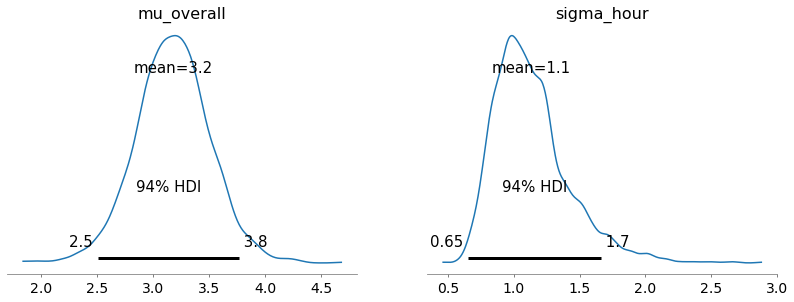

In [309]:
az.plot_posterior(idata, var_names=["mu_overall", "sigma_hour"]);

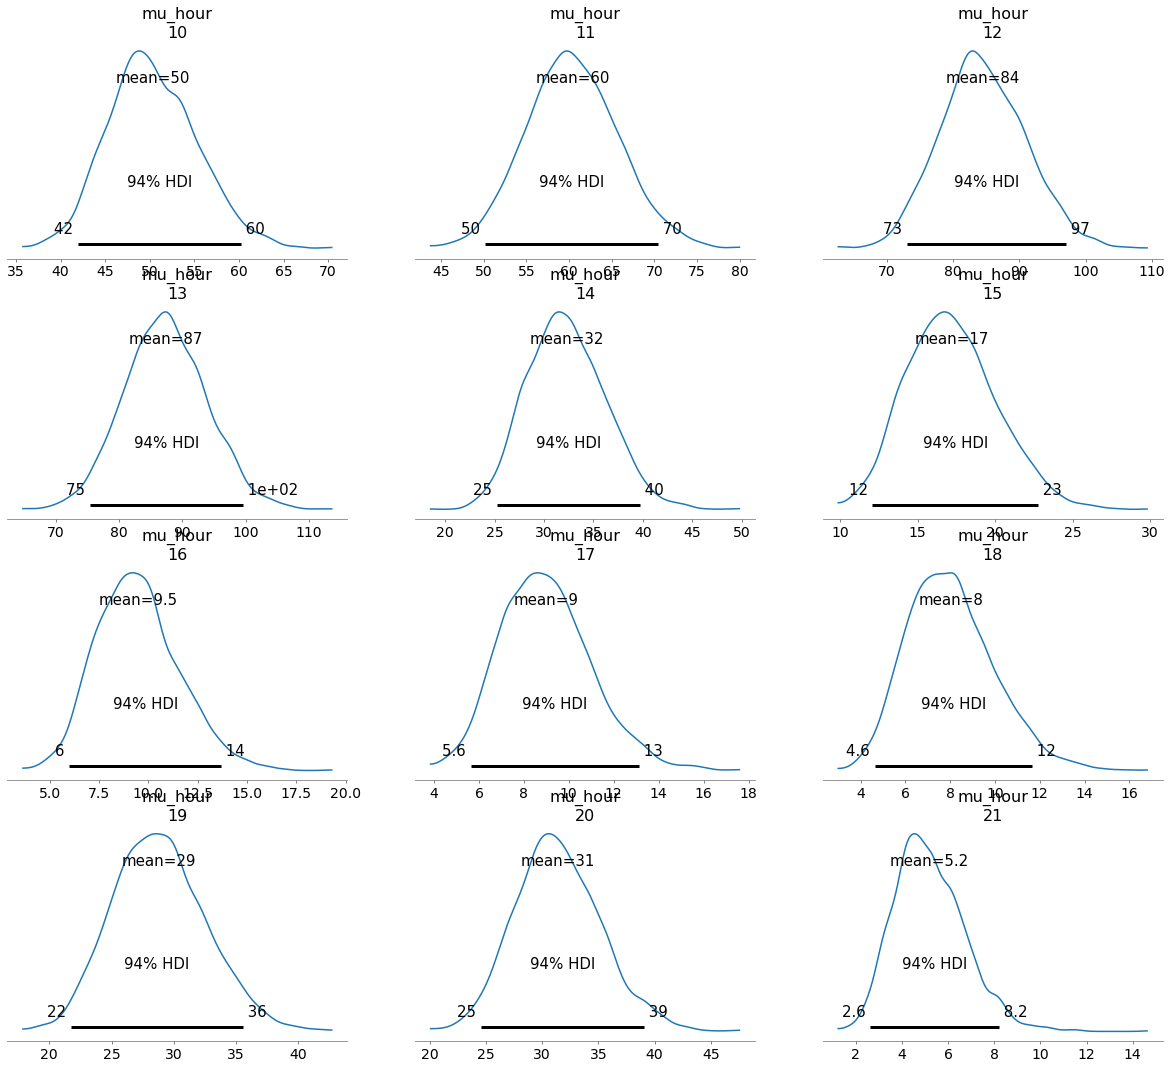

In [310]:
az.plot_posterior(idata, var_names=["mu_hour"], transform=np.exp);

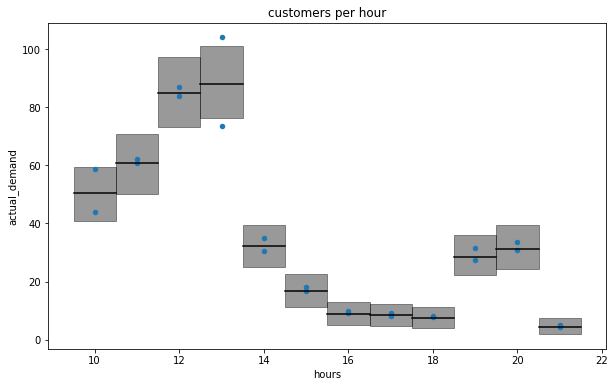

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
df_first_day.plot(kind="scatter", x="hours", y="actual_demand", ax=ax)
ax.set_title("customers per hour")
mu_hour = idata.posterior.mu_hour.stack(sample=["chain", "draw"])

hours = model.coords["hour"]
for i, hour in enumerate(hours):
    
    s = np.exp(mu.sel(hour=hour))
    lower, upper = az.hdi(s.values)
    
    mid = [np.median(s)]*2
    lb, ub = [lower]*2, [upper]*2
    x = [hour - 0.5, hour + 0.5]
    
    ax.plot(x, mid, color="k")
    ax.fill_between(x, lb, ub, color="k", alpha=0.4, zorder=-99)





One thing we are **not** taking into account here is time dependence, or the relationship between hours.  It's more likely that hour 10 and hour 11 are more alike in the number of customers, versus hour 10 and hour 16.  You might recognize the same concept of **distance**, except this time instead of neighborhoods, houses, and plane flights, the distance is in units of time, hours. 

Always remember that in Bayesian statistics, probability distributions represent how much information we have about a process, and also remember that the numerator of Bayes theorem is the likelihood times the prior, 
$$
p(\theta \mid \text{data}) = \frac{p(\text{data} \mid \theta) \times p(\theta)}{C}
$$
where C is really just some constant.

Right now, there's nothing in either the prior (one normal per hour) or the likelihood (also one normal per hour) that carries the information that we know to be true, that hour 10 is more similar to hour 11 than hour 16, etc.  

## Third model

Let's bring back our covariance function, the exponentiated quadratic.  We'll pick a lengthscale that makes sense to us and see how much adding this information to the model changes our inferences.  Remember that the exponentiated quadratic kernel function is
$$
k(x, x') = \exp{\left(\frac{-(x - x')^2}{2\ell^2}\right)} 
$$
To start, we'll set the lengthscale to one hour.  Then, we'll compute the covariance matrix and look at two plots that inform us what the covariance matrix is doing.

In [198]:
def exp_quad(x, x_prime, lengthscale):
    return np.exp( -0.5 * np.square(x - x_prime) / lengthscale**2)

lengthscale = 1.0

hours = df_first_day["hours"].values
K = np.zeros((len(hours), len(hours)))
for i, x in enumerate(hours):
    for j, x_prime in enumerate(hours):
        K[i, j] = exp_quad(x, x_prime, lengthscale)

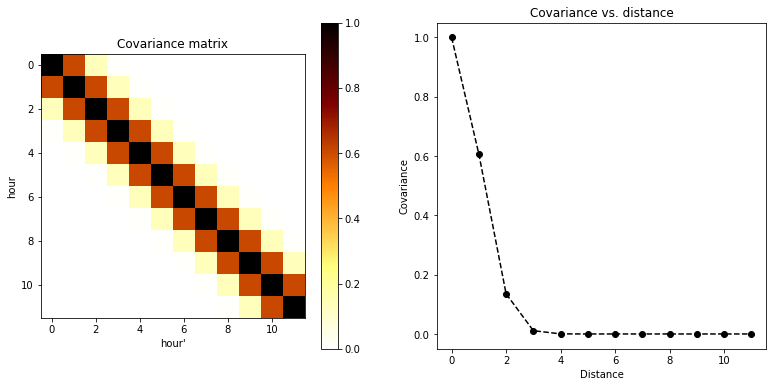

In [199]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
m = axs[0].imshow(K, cmap="afmhot_r"); plt.colorbar(m, ax=axs[0]);
axs[0].set_title("Covariance matrix")

d = np.arange(K.shape[0])
axs[1].plot(d, K[:, 0], "ko--");
axs[1].set_title("Covariance vs. distance");
axs[1].set_ylabel("Covariance");
axs[1].set_xlabel("Distance");

axs[0].set_ylabel("hour");
axs[0].set_xlabel("hour'");

The plot on the left is a heatmap of the actual covariance matrix.  This is very useful to get a feel for what you're including in your model.  Be sure though to sort your input variables (hour here) in some reasonable way, otherwise this matrix will look pretty random.

The plot on the right is the covariance as a function of distance, which as you may have gathered from the code, is just the first column (or row) of the covariance matrix `K`.  It clearly shows how rapidly the covariance decays with the time difference.  Here's that same plot with a few different lengthscales.

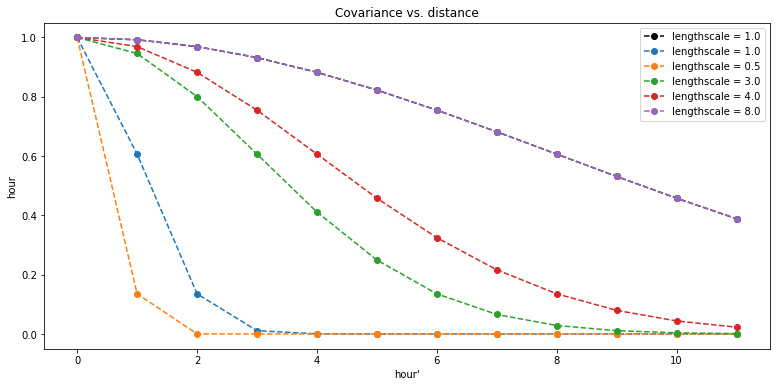

In [204]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
d = np.arange(K.shape[0])
ax.plot(d, K[:, 0], "ko--", label="lengthscale = 1.0");
ax.set_title("Covariance vs. distance");
ax.set_ylabel("Covariance");
ax.set_xlabel("Distance");
ax.set_ylabel("hour");
ax.set_xlabel("hour'");

for lengthscale in [1.0, 0.5, 3.0, 4.0, 8.0]:
    K = np.zeros((len(hours), len(hours)))
    for i, x in enumerate(hours):
        for j, x_prime in enumerate(hours):
            K[i, j] = exp_quad(x, x_prime, lengthscale)

    ax.plot(d, K[:, 0], "o--", label="lengthscale = %0.1f" % lengthscale);
    
ax.legend();

## Sec 51: An example using count data

First we're going to introduce an example of inferring the underlying rate of some pretty generic count data.  This part might be a review for you.  If it is, feel free to skip ahead or put it on 2x speed.  Afterwards, we're going to extend this example to add some time dependence which will motivate our next step towards developing GPs.  Here's your scenario:

Say you're modeling the amount of orders placed in your online shop, and you want to try estimate the number of orders placed per day.  Here's a plot of your raw data.

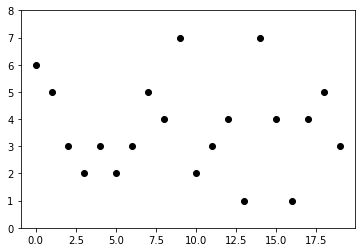

In [237]:
n_days = 20
true_avg_sales = 4
sales = np.random.poisson(lam=true_avg_sales, size=n_days)

plt.plot(np.arange(n_days), sales, "ok");
plt.ylim([0, max(sales) + 1]);

The first thing you should do is pull up your favorite SQL terminal and type something along the lines of `select avg(*) from sales group by day`, and then plot the counts, like we did above.  The next thing you can do is whip up a quick Bayesian model, which will help you understand the uncertainty in your estimate of the average.  Using PyMC, we can estimate the average number of sales per day using a Poisson likelihood, which is the default distribution for count data we have.  First we'll plot our prior (decide for yourself if you think it's reasonable -- feel free to experiment with other choices), then we'll write down the model.  It's amazing how much can be done in 5 lines of code.

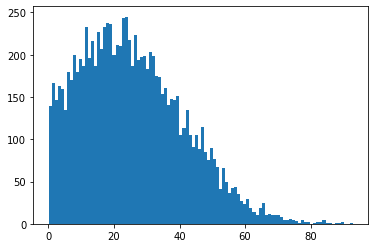

In [250]:
plt.hist(pm.draw(pm.TruncatedNormal.dist(mu=20, sigma=20, lower=0.0), 10000), 100);

In [251]:
with pm.Model() as model:
    avg_sales = pm.TruncatedNormal("avg_sales", mu=20, sigma=20, lower=0.0) # weakly informative prior constraints the avg_sales to be a positive number
    pm.Poisson("sales", mu=avg_sales, observed=sales)
    
    idata = pm.sample(tune=5000)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [avg_sales]
INFO:pymc:NUTS: [avg_sales]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 15 seconds.
INFO:pymc:Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.7127, but should be close to 0.8. Try to increase the number of tuning steps.


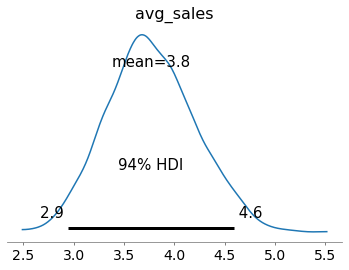

In [252]:
az.plot_posterior(idata, var_names=["avg_sales"]);

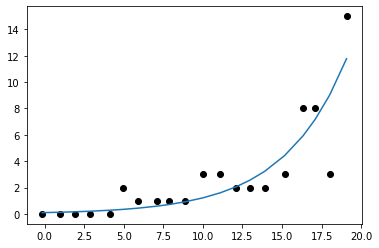

In [249]:
np.random.seed(50)

N = 20
x = np.arange(N) + 0.1*np.random.randn(N) # not exactly on round numbers

mu_true = 0.1 * np.exp(0.25 * x)
y = np.random.poisson(lam=mu_true)

plt.plot(x, y, "ok");
plt.plot(x, mu_true);

In [210]:
## model 1
N = len(x) # number of data points
with pm.Model() as model:
    
    # scale the variance of the prior
    eta = pm.HalfNormal("eta", sigma=1)
   
    # A multivariate normal random vector prior, with no correlation between elements
    mu = np.zeros(N)
    cov = eta**2 * np.diag(np.ones(N))
    f = pm.MvNormal("f", mu=mu, cov=cov)
    
    mu = pm.Deterministic("mu", pm.math.exp(f))
    lik = pm.Poisson("lik", mu=mu, observed=y)

with model:
    idata = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, f]
INFO:pymc:NUTS: [eta, f]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


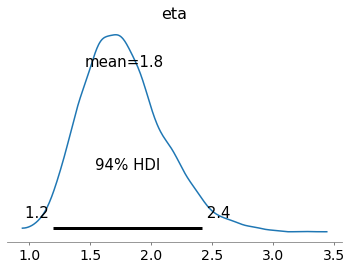

In [211]:
az.plot_posterior(idata, var_names=['eta']);

In [209]:
mu = idata.posterior.mu.stack(samples=['chain', 'draw']).values

plt.fill_between(x, np.percentile(mu, 5, axis=1), np.percentile(mu, 95, axis=1), edgecolor="k", color="slateblue", alpha=0.7)
plt.plot(x, np.mean(mu, axis=1), color="k");
plt.plot(x, y, "ok");

AttributeError: 'Dataset' object has no attribute 'mu'

We can see that's it's not really representing the data well.  `p` is kind of higher on the left and right, but not really.  There's also a lot of uncertainty.  Not to anthropomorphize, but our model doesn't know that data points that are near by in terms of $x$, should also be nearby in terms of $p$.  Nothing about the prior would indicate this.  It would take a lot more than 15 data points for the model to learn this relationship.  

So let's help it along.  Let's give the model a nudge in this direction by including this correlation in our prior.  We know that data points that are nearby in terms of $x$, should also be nearby in terms of $p$.  We don't know by how much though.  We can use kernels to parameterize these relationships though!  Remember the lengthscale parameter?  We don't know it, but we can put a prior on it.  

Putting priors on GP **hyperparameters** like `eta` and `lengthscale` is an important and topic on it's own.  For now we're just going to do something simple here, but we'll come back to this topic later.

In [156]:
## model 2
N = len(x) # number of data points
with pm.Model() as model:
    
    # scale the variance of the prior
    eta = pm.HalfNormal("eta", sigma=10)
    
    # The lengthscale is unknown, since we're Bayesians we put a prior on it
    lengthscale = pm.Uniform("lengthscale", lower=1, upper=20)

    # A multivariate normal random vector prior, with correlation between the inputs
    # We're using the pm.gp.cov.ExpQuad function in PyMC, which implements basically 
    # the same code that we wrote earlier in our function called "kernel".  You should
    # use it though, because extra care has gone into testing it and making it numerically
    # stable.  
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
    K = cov_func(x[:, None])
    
    ## This is the non-centered parameterization of a multivariate normal
    # without it, you wouldn't be able to sample from a GP.  This is an implementation
    # trick you need to do to make this work properly.  There are actually two implementation
    # tricks here, the second being adding a very small diagonal to the kernel matrix K.  Software libraries
    # like PyMC take care of this for you, so you won't need to worry about it in the future.
    K = at.linalg.cholesky(K + 1e-6*at.identity_like(K))
    v = pm.Normal("v", mu=0.0, sigma=1.0, size=len(x))
    f = at.dot(K, v)

    p = pm.Deterministic("p", pm.math.sigmoid(f))
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, lengthscale, v]
INFO:pymc:NUTS: [eta, lengthscale, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.


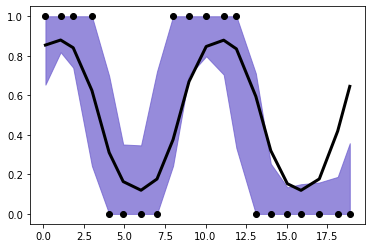

In [157]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

plt.fill_between(x, np.percentile(p, 5, axis=1), np.percentile(p, 95, axis=1), edgecolor="k", color="slateblue", alpha=0.7)
plt.plot(x, p_true, color="k", lw=3);
plt.plot(x, y, "ok");

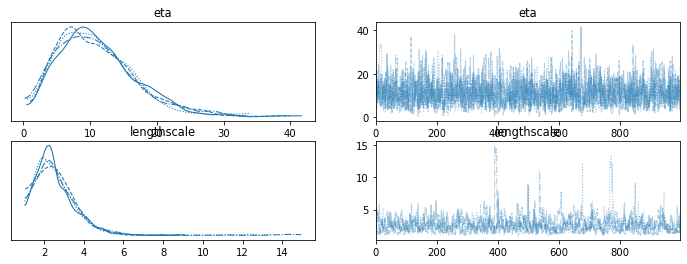

In [158]:
az.plot_trace(idata, var_names=["eta", "lengthscale"]);

## Things look much better!  But it's still a bit incomplete

To see, let's plot this a little differently.  We'll plot the same posterior samples but with dots instead of lines:

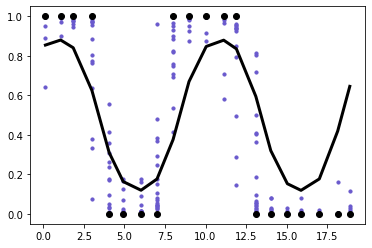

In [159]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

ix = np.random.randint(0, p.shape[1], 20)
for i in range(len(ix)):
    plt.scatter(x, p[:, i], color="slateblue", s=10);
plt.plot(x, p_true, color="k", lw=3);
plt.plot(x, y, "ok");

We'll add a very faint line now, to show which points are coming from which sample, but know that the data is only at the locations of the blue dots.

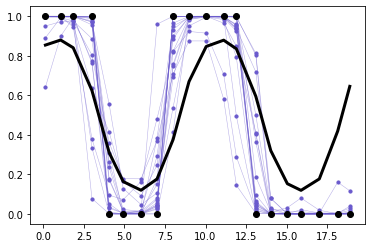

In [160]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

ix = np.random.randint(0, p.shape[1], 20)
for i in range(len(ix)):
    plt.scatter(x, p[:, i], color="slateblue", s=10);
    plt.plot(x, p[:, i], color="slateblue", lw=0.5, alpha=0.5);
plt.plot(x, p_true, color="k", lw=3);
plt.plot(x, y, "ok");

Here's the problem.  **We only predicted at the x locations of the observed data points**.  You'll notice that the dimensionality of the GP `f` (and then the transformed version `p`) is exactly the same as the data.

In [161]:
idata.posterior.p.shape # 4 chains, 1000 draws, 20 data points, one for each x

(4, 1000, 20)

In [163]:
x.shape # 20 x locations

(20,)

We really have a random vector here, not a random function.  In the next section, we'll show how we can combine the two facts that the covariance function is an actual function, and the number of dimensions of multivariate normals is somewhat flexible, to finally unveil Gaussian processes.

## Section Recap
* We wanted to classify checkout probability as a function of time
* We can assume our data was generated by one giant MVN
  * With uniform covariance our MVN is not able estimate similarity between points
  * With just a nudge from a kernel generated covariance our fit gets much better
* This almost a full Gaussian process
  * We can only make **in sample** predictions at observed data points
  * We cannot yet predict in sample or forecast to future outcomes
* To get this to sample well we need to apply a couple computational tricks
  * Modern GP libraries implement these for you under the hood

# Sec 60: Random functions

To have a GP, we need to realize that the *kernel is a function*.  **We can plug any x-values, not just the x-values where our data is located**.  This is why a GP is said to be infinite dimensional, because it can be seen at any `x` location (and there are infinite points on the `x` axis!)

Remember that function is a mathematical object, or a box, where you can give it an input, or an $x$ value (from the domain the function is defined over), and out from the other side comes some output value.  Let's take this one step at a time.  Using the same data and code, let's add a 16th data point to `x`, but one where we don't have any observations for `y`. 

Since we still only have 15 observed data points, (x, y) pairs, we need to index `p` to not include the new `x` we just added when we pass it into the likelihood.  (Remember that the likelihood is a function of the observed data).  Other than that, you'll see that the model code is the same. 

(ANIMATION HERE): have Fadi highlight the lines of code as we talk though them.  Like, "first MCMC proposes a value of eta, and lengthscale (highlight that)...". Talk through the fact that the covariance matrix K is 16 by 16 now (instead of 15 by 15 before).. 

In [164]:
# append the new x's to the end
x_new = 4.46 
x_both = np.concatenate((x, [x_new]))

with pm.Model() as model:
    # Since we don't know them, we put distributions on the parameters of the kernel, like the lengthscale
    eta = pm.HalfNormal("eta", sigma=1)
    lengthscale = pm.Uniform("lengthscale", lower=1, upper=5)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
  
    ## All that math can be written in a couple lines of code
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=x_both[:, None])
    
    p = pm.Deterministic("p", at.sigmoid(f))
    # index just the data points into the likelihood
    p = p[:len(x)]
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, lengthscale, f_rotated_]
INFO:pymc:NUTS: [eta, lengthscale, f_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


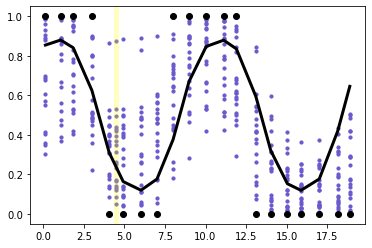

In [167]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

plt.axvline(x=x_new, color="yellow", alpha=0.25, lw=5)

ix = np.random.randint(0, p.shape[1], 20)
for i in range(len(ix)):
    plt.scatter(x_both, p[:, i], color="slateblue", s=10);
plt.plot(x, p_true, color="k", lw=3);
plt.plot(x, y, "ok");

Notice the yellow highlight at `x_new=4.46`.  It's not in the range of our original training data, but we've predicted some points there!  We added a dimension to our GP, so now instead of a 20 dimensional normal, it's now 21 dimensional.

Now how do we get a continuous function prediction?  Like anything with computers, you can't really represent "continuous" things -- but you can sample at enough points for things to be continuous enough for your purposes.  Instead of 20 + 1 points, let's do a lot, 20 + 100 points.  That should be enough for this to start "looking" continuous.  We'll use 100 x locations evenly spaced from -2 to 16, so both within the domain of our original `x` and outside of it.

(ANIMATION HERE): have Fadi highlight the lines of code as we talk though them.  Like, "first MCMC proposes a value of eta, and lengthscale (highlight that)...". Talk through the fact that the covariance matrix K is 115 by 115 now (instead of 15 by 15 before).. 

In [168]:
# append the new x's to the end.
x_new = 25 * np.random.rand(100) - 2
x_both = np.concatenate((x, x_new))

with pm.Model() as model:
    # Since we don't know them, we put distributions on the parameters of the kernel, like the lengthscale
    eta = pm.HalfNormal("eta", sigma=1)
    lengthscale = pm.Uniform("lengthscale", lower=1, upper=20)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
  
    ## All that math can be written in a couple lines of code
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=x_both[:, None])
    
    p = pm.Deterministic("p", at.sigmoid(f))
    # index just the data points into the likelihood
    p = p[:len(x)]
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, lengthscale, f_rotated_]
INFO:pymc:NUTS: [eta, lengthscale, f_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.


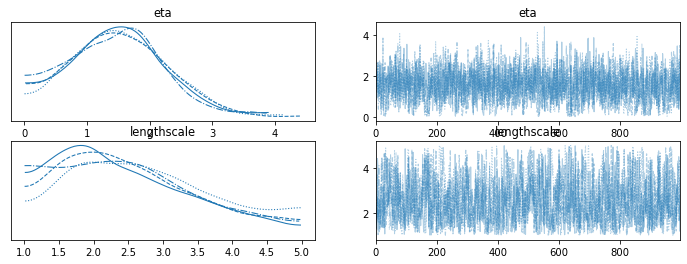

In [171]:
az.plot_trace(idata, var_names=["eta", "lengthscale"]);

Now look at the dots below.  They're basically lines.  

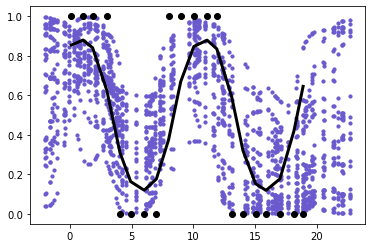

In [169]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

ix = np.random.randint(0, p.shape[1], 20)
for i in range(len(ix)):
    plt.scatter(x_new, p[len(x):, i], color="slateblue", s=10);
plt.plot(x, p_true, color="k", lw=3);
plt.plot(x, y, "ok");

Let's make things look a little nicer by plotting a few samples as lines, and then shading the rest of the posterior in now that we've sampled finely enough.

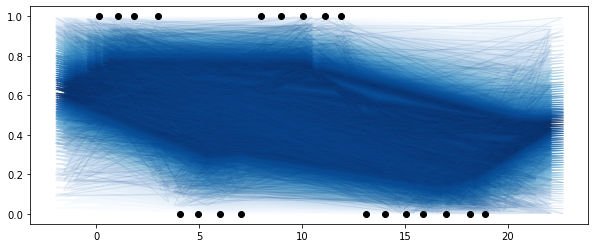

In [170]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

ix = np.random.randint(0, p.shape[1], 20)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
pm.gp.util.plot_gp_dist(ax, p[len(x):, :].T, x_new, palette="Blues")

plt.plot(x, y, "ok");

Congratulations on fitting your first GP!  We've managed to fill in and extrapolate our data to arbitrary locations.  This is actually the bare minimum you need to fit a GP to real data. 

# THE END

# ... But wait, is that really it?

In one major sense, yes.  Up until this point we've done 3 things:
1. Made a kernel function
2. Used the kernel as the covariance function of a multivariate normal
3. Fit data, and also used our kernel to extrapolate the GP to new `x` locations

At the simplest level, **that is what a GP is**, no more, and no less.  

$$
f \sim \mathcal{GP}\left(0\,, k(x, x')\right)
$$

However, you may have noticed one, very, very important thing:  When we added the extra 100 points, the runtime slowed **way, way** down, and we had to fit and predict at the same time.  This slow runtime is the Achilles heel of Gaussian processes, which have $\mathcal{O}^3$ computational complexity.  This means that as the size of the data set grows, the runtime scales cubicly!  Just about every other ML algorithm in say, scikit-learn, scales much better than this.

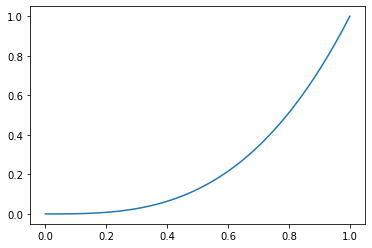

In [115]:
x = np.linspace(0, 1, 100)
y = x**3

plt.plot(x, y);

### Then why does any one actually use them in practice if they are so slow?

Two reasons:

1. GPs are effective modeling tools because they are extremely expressive.  Remember the line and cosine model we first tried to use to fit the Mauna Loa data set?  There are many different types of kernel functions, all of which produce functions with different characteristics.  Also, unlike many scikit-learn models, the results have an interpretation.  Remember the lengthscale parameter?  Although they can represent super complicated functions, GP's aren't really blackbox ML models.

2. There are ways to speed them up.  With (sometimes quite a bit of) math, there are different approximations and also different scenarios where GPs can be sped up, sometimes dramatically.  Using GPs in practice really means knowing when and where to use which approximations.     

So to summarize:
- GP's are extremely expressive modeling tools (interpretable too!)
- GP's are slow

In [55]:
x = np.linspace(0, 10, 200)
cov = pm.gp.cov.ExpQuad(1, ls=2)
K = cov(x[:, None]).eval()
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(200), cov=K), 25)

this

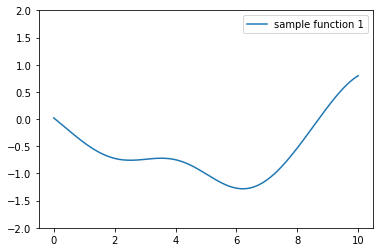

In [56]:
plt.plot(x, s[0, :], color="C0", label="sample function 1");
plt.ylim([-2, 2]);
plt.legend();

and this

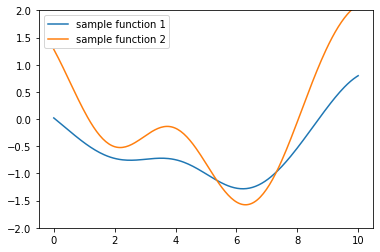

In [57]:
plt.plot(x, s[0, :], color="C0", label="sample function 1");
plt.plot(x, s[1, :], color="C1", label="sample function 2");
plt.ylim([-2, 2]);
plt.legend();

and then this

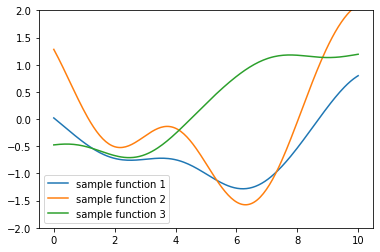

In [58]:
plt.plot(x, s[0, :], color="C0", label="sample function 1");
plt.plot(x, s[1, :], color="C1", label="sample function 2");
plt.plot(x, s[2, :], color="C2", label="sample function 3");
plt.ylim([-2, 2]);
plt.legend();

Here are many many samples

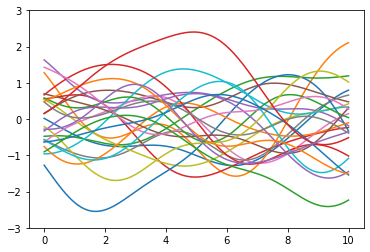

In [59]:
plt.plot(x, s.T);
plt.ylim([-3, 3]);

Unlike a random vector, all of these different paths are functions.  Yes, if we plotted these as dots we'd see that these aren't perfectly smooth lines, BUT, we could plug in more x's wherever we want (functions!) and all the lines would smoothly extend out past 10.

- A normal distribution is an example of a probability distribution over values
- A multivariate normal distribution is an example of a probability distribution over vectors
- **A Gaussian process** is an example of a probability distribution over functions

The key to this whole thing is the covariance function we built before, $k(x, x)'$  Since it's a function of $x$, *and* we can use it as a covariance in a multivariate normal, it allows us to convert the *dimensions* of the multivariate normal, into points on $x$.  

The line between a random vector and a random function may seem a little blurry too.  

- If you observe 5 points along a random function, so only 5 x locations, is that a length 5 random vector? Yes!
- The difference is for random functions there is *a way* to interpolate and extrapolate.  For GPs, that way is the fact that the kernel is a function of $x$.   

## Section Recap

**This section needs a tiny bit more work to explain how we move from discrete to continuous** Likely along the lines of

Instead of just generating a covariance for the data we seen, what if instead we plugged in a value of x and **any other possible value of x**. This is what we did in the Mauna Lao example, were just doing the same here.

Getting real section in here explains it well as does the markdown block right below. Maybe we should move that up into this section?

https://thegradient.pub/gaussian-process-not-quite-for-dummies/

# Sec 70: Gaussian processes

Alright, here it is.  A GP is usually written down as,

$$
f(x) \sim \mathcal{GP}\left(0\,, k(x, x')\right) \,.
$$

Read this as: "The function f(x) is distributed as a Gaussian process with mean zero and covariance function $k(x, x')$.  If we take a fixed set of $x$ values and plug them in, it becomes a multivariate normal random vector.  But before that, since the kernel $k$ is a function over $x$ and $x'$, we have a distribution over functions.  Since there are an infinite number of $x$ values you could plug in (because $x$ can be any number, right?), people say that GPs are an infinite dimensional distribution.  

When we plug in some $x's$, we get a multivariate normal random vector, with elements for each $x$ we plugged in.

$$
\mathbf{f}_x \sim \mathcal{N}\left(0\,, \mathbf{K}_{xx}\right) \,.
$$

We've seen lot's of examples of this already!  Here's some code you've already seen, but now with some annotations.  We are drawing samples from a Gaussian process prior.

## GP Prior

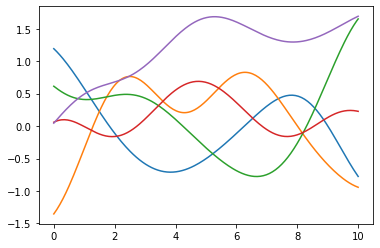

In [62]:
x = np.linspace(0, 10, 200)  # a fixed set of x's, 200 of them. 
cov = pm.gp.cov.ExpQuad(1, ls=2) # a covariance *function*
K_xx = cov(x[:, None]).eval() # evaluate the covariance function over the fixed set of x's, now it's a matrix K_xx
f_x = pm.draw(pm.MvNormal.dist(mu=np.zeros(200), cov=K_xx), 5)  # draw 5 samples of the GP over the fixed set of x's

plt.plot(x, f_x.T);

And now, let's fit our first GP -- **and** let's get some predictions.  Let's use the example from earlier, where we technically we did fit a GP -- but without making predictions at arbitrary $x$.  Let's consider two regions of the domain $x$.  The first is where our data is, this is `x` in the code below.  We'll denote where we want predictions as `xs`.  

## GP Posterior

In [63]:
x = 5 * np.sort(np.random.rand(100))
xs = np.linspace(np.max(x), 10, 100)
x_both = np.concatenate((x, xs))

with pm.Model() as model:
    # Since we don't know them, we put distributions on the parameters of the kernel, like the lengthscale
    eta = pm.HalfNormal("eta", sigma=1)
    lengthscale = pm.Uniform("lengthscale", lower=1, upper=5)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
  
    ## All that math can be written in a couple lines of code
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=x_both[:, None])
    
    p = pm.Deterministic("p", at.sigmoid(f))
    # index just the data points into the likelihood
    p = p[:len(x)]
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.9)

Compiling...
Compilation time =  0:00:02.043777
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:08:29.338653
Transforming variables...
Transformation time =  0:00:09.266784
Computing Log Likelihood...
Log Likelihood time =  0:00:08.924947


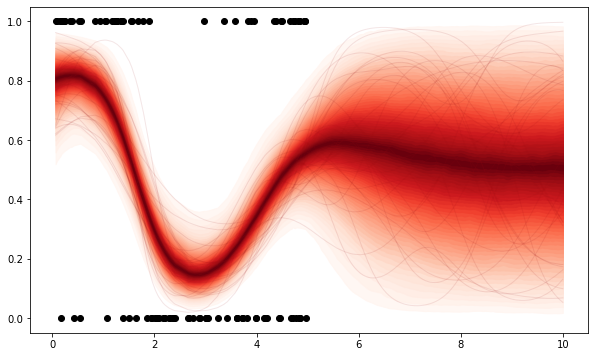

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

p = idata.posterior.p.stack(samples=['chain', 'draw']).values

pm.gp.util.plot_gp_dist(ax, p.T, x=x_both)
plt.plot(x, y, "ok");

It may seem like a minor detail, or an issue about semantics, but the idea of functions over arbitrary x, and a fixed set of x's, is key to what sets GP's apart.  Also notice that we have to fit and predict at the same time.  To do so, we just index our GP points where we have observed data at, the rest are our predictions.

This is what makes GPs such effective modeling tools -- they are extremely expressive.  Remember the line and cosine model we first tried to use to fit the Mauna Loa data set?  GPs are distribution over functions that are defined by the idea of similarity, instead of parameters like slope and y-intercept, or frequency, amplitude and phase.  This is why they are called **non-parametric** models, while models like the line and cosine model are called **parametric** models.  Non-parametric models generally need the whole training data set on hand to make predictions, which is technically true for GPs as well, as we'll see in the next section.  We won't worry too much about the distinction in this course, but you will see these terms around in other places, so this is what they mean.  

## Section Recap (Partially complete pending comment)
* This is where Bayes Formula comes in
  * Our prior functions are ranked by likelihood to determine the ones that are most likely
* This ability to generate random functions and then determine what is most likely is why GPs can "fit anything"
  * This flexibility is also what unfortunately what makes GPs so slow
* There sometimes is a distinction between parametric and non parametric models
  * For practitioners this distinction is not too important

# Sec 80: Conclusion

And that's the basics of GPs! GPs can be boiled down to the sum of two main ingredients, kernels and multivariate Gaussians.  You may have already noticed though that sampling is a bit slow.  This would be foreshadowing for what happens next...  If you take away two things from this course, it should be:

1.  At their core, GPs are simple, and elegent.  You can model many, many kinds of random functions as giant multivariate normal distributions, with a kernel function for the covariance.  The kernel function you use determines the model.  
2.  Scaling GPs to larger data sets is **hard**.  It's not an exaggeration to say that for everything you'll learn about GPs (other than the behaviors of different kernel functions) is about scaling GPs to larger data sets, and making them run faster, and just making them practically usable.
3.  In order for GPs to be usable in all but the simplest cases, you need to fit and predict as a two step process.  We'll show how to do this in a later lesson, when we learn about conditioning and marginalization of multivariate normals.

For instance, in nearly any practical situation, you don't want to fit and predict all in one step, since fitting is so much slower.  The next lesson is about how to condition in GPs to make fitting and predicting a two step process.  Then, the lesson after that one is about the special case where the likelihood is also Gaussian, like in the Mauna Loa example above (but not like the logistic regression example).  There we can exploit something called *conjugacy* to avoid explicitly sampling the GP at the observed data $f$.  If it seems hard to imagine how that's possible, we'll explain later.

The point is, these two concepts are so important for using GPs in practice, that people often include them *when explaining what a GP even is* -- even though as you can see above, we "can" understand, fit, and predict with GPs without them.  

The rest of this course we'll gain a deeper understanding of GPs, challenges to using them in practice.  We'll cover many different type of kernels, beyond those we showed above.  We'll also cover a few very important GP approximations that you'll need when working with real data, at least if it has more than a couple hundred data points.  Most importantly, we'll learn about how to use GPs effectively to create **good** and useful models. 